# Laboratorio 2

In [210]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from skimage import io, color
from skimage.filters import prewitt_h, prewitt_v
import matplotlib.patches as patches
from skimage.transform import resize
import math
from skimage.draw import line

In [211]:
def preprocess_image(image):
    if np.max(image) <= 1.0:
        image = (image * 255).astype(np.uint8)
    return image

In [212]:
def show_image(image, vmin=0, vmax=255):
    image = preprocess_image(image)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()

## Ejercicio 1

In [213]:
def convert_gray_scale(image):
    """Convert image to gray scale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [214]:
def rescale_image(image, k, n_width=128, n_height=64):
    """Rescale image by factor k."""
    new_height = n_height
    new_width = n_width
    new_shape = (int(new_width * k), int(new_height * k))
    return resize(image, new_shape)

In [215]:
def read_and_preprocess_image(image_path, k=1, n_width=128, n_height=64):
    """Read image from file and preprocess it."""
    image = cv2.imread(image_path)
    image = convert_gray_scale(image)
    image = rescale_image(image, k, n_width, n_height)
    return image

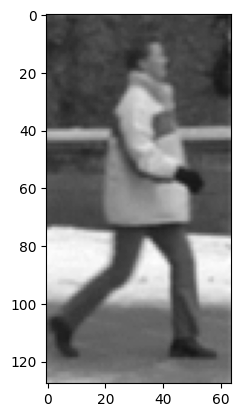

In [216]:
image = read_and_preprocess_image('images/person.png')
show_image(image)

## Ejercicio 2

In [217]:
def calcular_gradiente(imagen):
    imagen = preprocess_image(imagen)
    # Definir los filtros de Prewitt para calcular las correlaciones Gx y Gy
    filtro_prewitt_y = np.array([[-1, 0, 1],
                                  [-1, 0, 1],
                                  [-1, 0, 1]])
    filtro_prewitt_x = np.array([[-1, -1, -1],
                                  [0, 0, 0],
                                  [1, 1, 1]])

    # Realizar convolución de la imagen con los filtros de Prewitt
    gradiente_x = convolve2d(imagen, filtro_prewitt_x, mode='same', boundary='symm')
    gradiente_y = convolve2d(imagen, filtro_prewitt_y, mode='same', boundary='symm')

    # Calcular la magnitud del gradiente
    magnitud_gradiente = np.sqrt(gradiente_x**2 + gradiente_y**2)

    # Calcular el ángulo del gradiente en radianes
    angulo_gradiente = np.arctan2(gradiente_y, gradiente_x)

    # Convertir el ángulo a grados y asegurar que esté en el rango 0 <= θ < 180
    angulo_gradiente_grados = np.degrees(angulo_gradiente) % 180

    return magnitud_gradiente, angulo_gradiente_grados


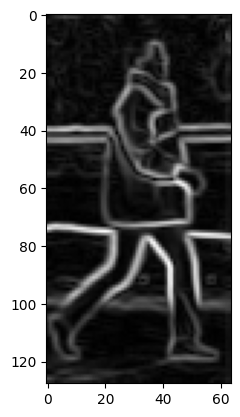

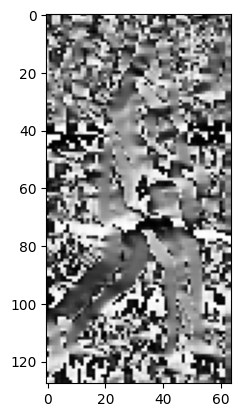

In [218]:
gradient_magnitude, gradient_angle = calcular_gradiente(image)
show_image(gradient_magnitude, vmax=np.max(gradient_magnitude))
show_image(gradient_angle, vmax=np.max(gradient_angle))

## Ejercicio 3

In [219]:
def build_block_stack(magnitud_gradiente, angulo_gradiente, block_size=8, stride=None):
    if stride is None:
        stride = block_size // 2
    # Calcular M y N según las fórmulas dadas
    M = magnitud_gradiente.shape[0] // (stride)
    N = magnitud_gradiente.shape[1] // (stride)

    # Inicializar los arrays para el stack de bloques de magnitud y ángulo del gradiente
    block_magnitude = np.zeros((M * N, block_size, block_size))
    block_angle = np.zeros((M * N, block_size, block_size))

    # Rellenar los arrays con los bloques de magnitud y ángulo del gradiente
    block_index = 0
    for y in range(M):
        for x in range(N):
            # Determinar la posición del bloque
            start_y = y * stride
            start_x = x * stride
            end_y = start_y + block_size
            end_x = start_x + block_size

            # Extraer los bloques de magnitud y ángulo y almacenarlos
            block_magnitude[block_index] = magnitud_gradiente[start_y:end_y, start_x:end_x]
            block_angle[block_index] = angulo_gradiente[start_y:end_y, start_x:end_x]

            block_index += 1

    return block_magnitude, block_angle


In [220]:
blocks_magnitude, blocks_angle = build_block_stack(gradient_magnitude, gradient_angle, stride=8)
print(blocks_magnitude.shape)

(128, 8, 8)


## Ejercicio 4

In [221]:
def visual_histogram(histogram):
    fig, ax = plt.subplots()
    ax.bar(range(len(histogram)), histogram, color='b')
    plt.show()

In [222]:
def normalize_histogram(histogram, epsilon=1e-5):
    histogram = histogram / np.sqrt(np.linalg.norm(histogram)**2 + epsilon)
    return histogram


In [223]:
# def construir_histograma_de_gradientes(block_magnitude, block_angle, num_bins=9):
#     # Inicializar el array para el histograma de gradientes
#     H = np.zeros((block_magnitude.shape[0], num_bins))
#     delta_angulo = 180 / num_bins

#     # Calcular los centros de cada bin
#     centros_bins = np.array([delta_angulo / 2 + i * delta_angulo for i in range(num_bins)])
#     for block_index in range(block_magnitude.shape[0]):
#         magnitudes = block_magnitude[block_index]
#         angulos = block_angle[block_index]

#         histograma = np.zeros(num_bins)
#         for i in range(magnitudes.shape[0]):
#             for k in range(magnitudes.shape[1]):
#                 mu = magnitudes[i, k]
#                 theta = angulos[i, k] % 180
#                 j = int(theta / delta_angulo)
                
#                 distancia_centro = abs(theta - (j * delta_angulo + delta_angulo / 2))
                
#                 # Calcula la contribución a los bins vecinos
#                 contribucion_principal = mu * (1 - (distancia_centro / delta_angulo))
#                 contribucion_vecino = mu - contribucion_principal

#                 # Asigna la contribución a los bins
#                 histograma[j] += contribucion_principal
#                 if theta > (j * delta_angulo + delta_angulo / 2):
#                     # Si theta está más cerca del bin siguiente
#                     histograma[(j + 1) % num_bins] += contribucion_vecino
#                 else:
#                     # Si theta está más cerca del bin anterior
#                     histograma[j - 1] += contribucion_vecino
                    
#         H[block_index] = normalize_histogram(histograma)
#     return H

In [224]:
def construir_histograma_de_gradientes(block_magnitude, block_angle, num_bins=9):
    # Inicializar el array para el histograma de gradientes
    H = np.zeros((block_magnitude.shape[0], num_bins))
    delta_angulo = 180 / num_bins

    for block_index in range(block_magnitude.shape[0]):
        magnitudes = block_magnitude[block_index]
        angulos = block_angle[block_index]

        histograma = np.zeros(num_bins)
        for i in range(magnitudes.shape[0]):
            for k in range(magnitudes.shape[1]):
                mu = magnitudes[i, k]
                theta = angulos[i, k] % 180
                # theta = np.deg2rad(theta)
                j = math.floor((theta / delta_angulo) - 0.5)

                c_j = delta_angulo * (j + 0.5)
                c_j_1 = delta_angulo * (j + 1.5)

                
                if j < 0:
                    histograma[0] += mu
                elif j + 1 >= num_bins:
                    histograma[num_bins - 1] += mu
                else:
                    v_j = mu * (c_j_1 - theta) / delta_angulo
                    v_j_1 = mu * (theta - c_j) / delta_angulo
                    histograma[j] += v_j
                    histograma[j + 1] += v_j_1

                    
        # H[block_index] = normalize_histogram(histograma)
        H[block_index] = histograma
    return H

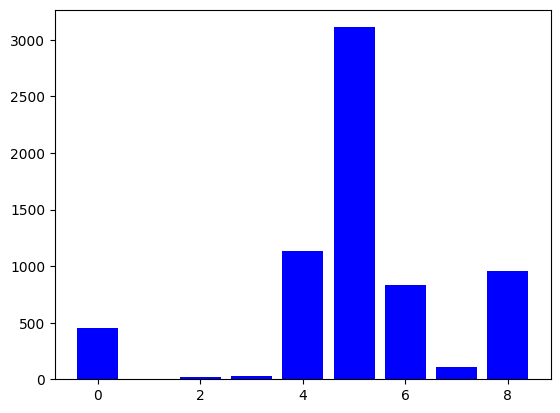

In [225]:
histograms = construir_histograma_de_gradientes(blocks_magnitude, blocks_angle)
visual_histogram(histograms[102])

## Ejercicio 5

In [239]:
def visualize_hog(H, image_shape, cell_size=8):
    delta_angulo = 180 / H.shape[1]
    radius = cell_size // 2 - 1
    blocks = []
    M = image_shape[0] // cell_size
    N = image_shape[1] // cell_size 
    max = np.max(H)
    min = np.min(H)
    center = (cell_size // 2, cell_size // 2)
    for histogram in H:
        block = np.zeros((cell_size, cell_size))
        for i in range(H.shape[1]):
            magnitude = histogram[i]
            magnitude = (magnitude - min) / (max - min)
            # Basado en skimage https://github.com/scikit-image/scikit-image/blob/main/skimage/feature/_hog.py
            angle =  90 + (i * delta_angulo + (delta_angulo)) % 180
            dr = radius * np.sin(np.radians(angle))
            dc = radius * np.cos(np.radians(angle))
            r0 = int(center[0] - dc)
            c0 = int(center[1] - dr)
            r1 = int(center[0] + dc)
            c1 = int(center[1] + dr)
            rr, cc = line(r0, c0, r1, c1)
            block[rr, cc] += magnitude
        blocks.append(block)
    
    blocks = np.array(blocks)
    blocks = blocks.reshape((M, N, cell_size, cell_size))
    image = np.block([[blocks[i, j] for j in range(N)] for i in range(M)])
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return normalized_image


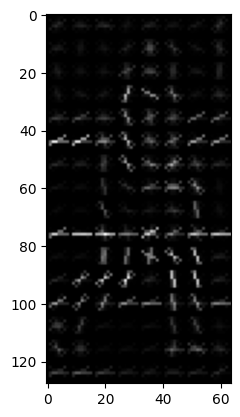

In [240]:
xd = visualize_hog(histograms, image.shape)
show_image(xd)

En la comparación entre nuestra implementación del algoritmo HOG y la versión proporcionada por scikit-image, es crucial considerar las diferencias en el manejo de los ángulos en los gradientes y la representación visual de las imágenes. En nuestra implementación, los ángulos de los gradientes se calculan utilizando la función np.arctan2(gradiente_y, gradiente_x) y luego se convierten a grados, lo que resulta en un rango de ángulos de 0 a 180 grados. Por otro lado, scikit-image puede utilizar una convención diferente para representar los ángulos, posiblemente en el rango de -90 a 90 grados, donde los valores negativos indican direcciones opuestas al eje horizontal. Esta diferencia en la representación de los ángulos podría influir en la generación de los histogramas de orientación en el siguiente paso del algoritmo HOG, lo que a su vez afectaría las características HOG finales.

En cuanto a la representación visual de las imágenes, nuestra implementación visualiza las características HOG dibujando líneas radiales correspondientes a los ángulos de los gradientes en cada celda de la imagen. Este enfoque crea una representación visual en la que las líneas se extienden desde el centro de cada celda en la dirección del gradiente, lo que puede dar la impresión de líneas inclinadas en lugar de líneas horizontales. Por otro lado, la visualización de las características HOG en scikit-image puede seguir una representación visual diferente, posiblemente utilizando convenciones visuales como la codificación de color o la superposición de flechas que indican la dirección del gradiente. Estas diferencias en la representación visual pueden conducir a percepciones visuales distintas de las características HOG, incluso si las características subyacentes son similares.

En conclusion , las discrepancias en los resultados entre las implementaciones pueden atribuirse a las diferencias en el manejo de los ángulos en los gradientes y en la representación visual de las imágenes. Comprender y tener en cuenta estas diferencias es fundamental para una comparación precisa y significativa de las características extraídas mediante el algoritmo HOG.

## Ejercicio 6

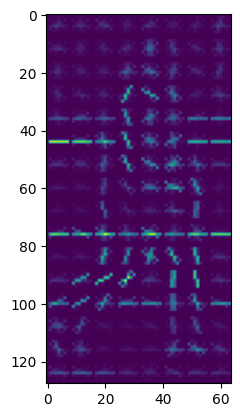

In [228]:
from skimage.feature import hog
fd, hogI = hog(image.copy(), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

plt.figure()
plt.imshow(hogI)
plt.show()

## Ejercicio 7

In [233]:
def person_detection(image_path):
    I = cv2.imread(image_path)
    # Crear un descriptor HOG
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())  # Método corregido

    # Detectar peatones
    locations, confidence = hog.detectMultiScale(I)

    # Dibujar rectángulos alrededor de los peatones detectados
    for (x, y, w, h) in locations:
        cv2.rectangle(I, (x, y), (x + w, y + h), (0, 0, 255), 5)

    # Convertir la imagen a RGB para mostrarla con Matplotlib
    I_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

    # Mostrar la imagen
    plt.figure(figsize=(10, 5))
    plt.imshow(I_rgb)
    plt.axis('off')
    plt.show()

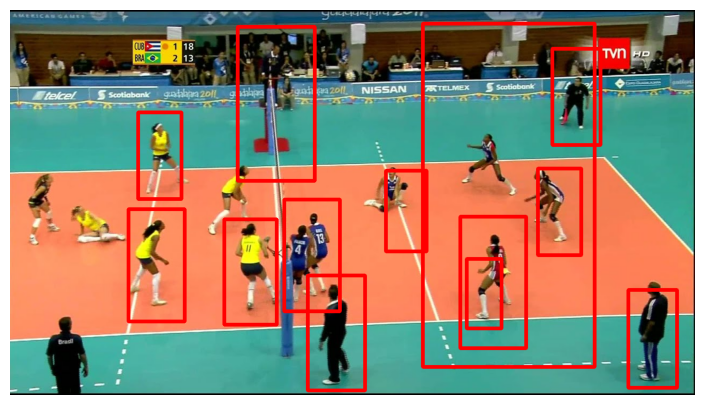

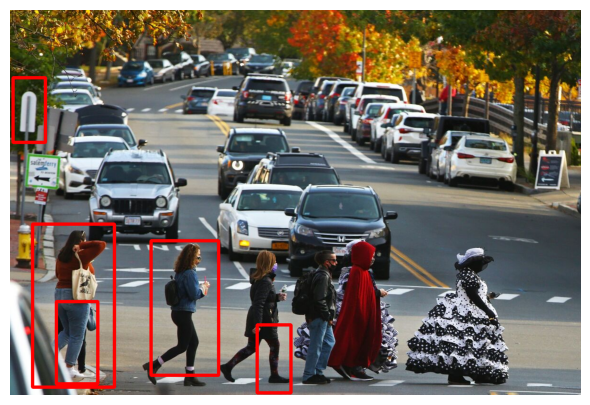

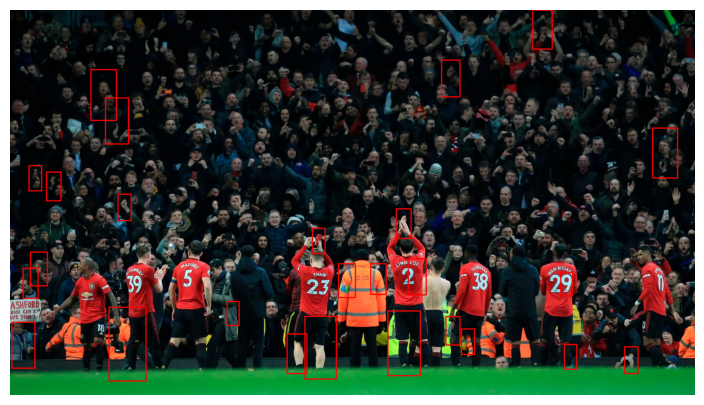

In [238]:
person_detection('images/volei.jpeg')
person_detection('images/pedestrians.png')
person_detection('images/football.png')